# Topic Modeling Clustering

In this notebook we visualize a previously generated topic model.

# Set Up

## Imports

In [60]:
import pandas as pd
import numpy as np

## Configuration

In [61]:
# data_prefix = 'jstor_hyperparameter'
data_prefix = 'winereviews'
db_dir = './db'

In [62]:
data_prefix

'winereviews'

## Import Topic Data

We import our previously generated model.

In [63]:
# topic_model_suffix = '_NMF'
topic_model_suffix = ''

In [64]:
LABELS = pd.read_csv(f"{db_dir}/{data_prefix}-LABELS.csv").set_index('doc_id')
VOCAB = pd.read_csv(f"{db_dir}/{data_prefix}-VOCAB.csv").set_index('term_str')
BOW = pd.read_csv(f"{db_dir}/{data_prefix}-BOW.csv").set_index(['doc_id','term_str'])
TOPICS = pd.read_csv(f"{db_dir}/{data_prefix}-TOPICS{topic_model_suffix}.csv").set_index('topic_id')
THETA = pd.read_csv(f"{db_dir}/{data_prefix}-THETA{topic_model_suffix}.csv").set_index('doc_id')
THETA.columns.name = 'topic_id'
THETA.columns = [int(col) for col in THETA.columns] # Should change columns to strings
PHI = pd.read_csv(f"{db_dir}/{data_prefix}-PHI{topic_model_suffix}.csv").set_index('topic_id')
PHI.columns.name = 'term_str'

In [65]:
n_topics = len(TOPICS)
topic_cols = [t for t in range(n_topics)]

# Inspect Results

## Sort Topics by Doc Weight

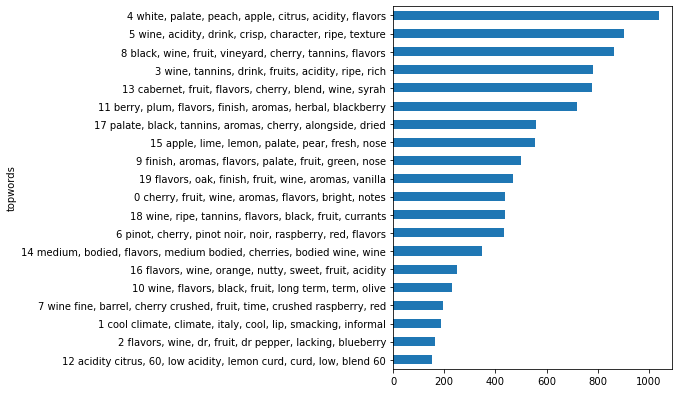

In [66]:
TOPICS.sort_values('doc_weight_sum', ascending=True)\
    .plot.barh(y='doc_weight_sum', x='topwords', figsize=(5, n_topics/3), legend=False);

## Clutser Topics

In [67]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [68]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, n_topics / 3))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [69]:
SIMS = pdist(normalize(PHI), metric='cosine')
TREE = sch.linkage(SIMS, method='ward')

<Figure size 432x288 with 0 Axes>

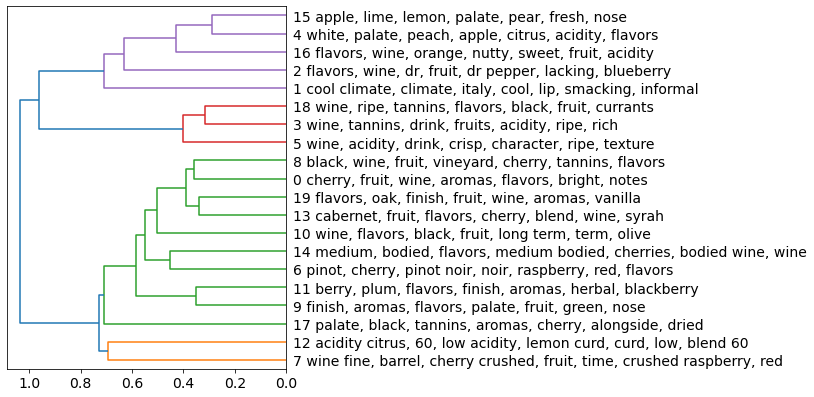

In [70]:
plot_tree(TREE, TOPICS.topwords.to_list());

## Group Topics by Label

In [71]:
LABELS.columns

Index(['doc_taster', 'doc_province', 'doc_price', 'doc_title', 'doc_label',
       'doc_place', 'doc_variety', 'doc_points'],
      dtype='object')

In [72]:
group_col = 'doc_label'
# group_col = 'doc_srccat'

In [73]:
group_vals = LABELS[group_col].value_counts().to_frame('n')
group_vals.index.name = 'group_id'

In [74]:
group_vals

,n
group_id,
US,4277
France,1741
Italy,1493
Spain,513
Portugal,387
Chile,319
Argentina,297
Austria,253
Germany,165


In [75]:
# group_vals.sort_values('n').plot.barh(figsize=(5,len(group_vals) / 3), legend=False);

In [76]:
G = THETA.join(LABELS).groupby(group_col)[topic_cols].mean()
G.index.name = 'group_id'
G.columns = TOPICS.topwords

### Heatmap of Labels and Topics

In [77]:
# G.style.background_gradient()

### Top Topic per Label Group

In [78]:
group_vals['top_topic'] = G.T[group_vals.index].idxmax()

In [79]:
group_vals.sort_values('top_topic')

,n,top_topic
group_id,,
Bulgaria,10,"0 cherry, fruit, wine, aromas, flavors, bright..."
Ukraine,1,"0 cherry, fruit, wine, aromas, flavors, bright..."
Israel,32,"0 cherry, fruit, wine, aromas, flavors, bright..."
Spain,513,"11 berry, plum, flavors, finish, aromas, herba..."
Chile,319,"11 berry, plum, flavors, finish, aromas, herba..."
Argentina,297,"11 berry, plum, flavors, finish, aromas, herba..."
Brazil,2,"11 berry, plum, flavors, finish, aromas, herba..."
Canada,18,"13 cabernet, fruit, flavors, cherry, blend, wi..."
New Zealand,108,"14 medium, bodied, flavors, medium bodied, che..."


### Top Label Group per Topic

In [80]:
G.idxmax().to_frame('label').sort_values('label')

,label
topwords,
"9 finish, aromas, flavors, palate, fruit, green, nose",Armenia
"15 apple, lime, lemon, palate, pear, fresh, nose",Armenia
"12 acidity citrus, 60, low acidity, lemon curd, curd, low, blend 60",Bulgaria
"13 cabernet, fruit, flavors, cherry, blend, wine, syrah",Canada
"11 berry, plum, flavors, finish, aromas, herbal, blackberry",Chile
"2 flavors, wine, dr, fruit, dr pepper, lacking, blueberry",England
"5 wine, acidity, drink, crisp, character, ripe, texture",France
"18 wine, ripe, tannins, flavors, black, fruit, currants",France
"1 cool climate, climate, italy, cool, lip, smacking, informal",Georgia
